In [67]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns

In [68]:
reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
reply.encoding = 'utf-8'

In [115]:
csv_data = reply.text
df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False, header=0)
for i, name in enumerate(df.columns):
    print(i, name)

0 Project Reference
1 Academic Year
2 Mobility Start Month
3 Mobility End Month
4 Mobility Duration
5 Activity (mob)
6 Field of Education
7 Participant Nationality
8 Education Level
9 Participant Gender
10 Participant Profile
11 Special Needs
12 Fewer Opportunities
13 Participant Age
14 Sending Country Code
15 Sending City
16 Sending Organization
17 Receiving Country Code
18 Receiving City
19 Receiving Organization
20 Participants


In [136]:
mobility_df = df[df[df.columns[10]]=='Learner']
mobility_df = mobility_df[mobility_df['Activity (mob)'].str.contains('Student')]
mobility_df = mobility_df[~mobility_df['Activity (mob)'].str.contains('traineeship')]
# consideriamo solo l'anno accademico 2018/2019 o 2017/2018?
# i numeri cambiano parecchio di anno in anno, è normale?
#mobility_df = mobility_df[mobility_df['Academic Year'].str.contains('19')]
mobility_df = mobility_df.loc[:, df.columns[np.array((16, 19, 20, 5))]]
print((mobility_df['Receiving Organization'].nunique()))
print((mobility_df['Sending Organization'].nunique()))

3759
4264


In [137]:
for index in range(len(mobility_df['Sending Organization'])):
    s_uni = mobility_df.iat[index,0]
    r_uni = mobility_df.iat[index,1]
    if s_uni != s_uni.upper():
        mobility_df.iat[index,0] = s_uni.upper()
    if r_uni != r_uni.upper():
        mobility_df.iat[index,1] = r_uni.upper()

print('Number of Receiving Universities: ',(mobility_df['Receiving Organization'].nunique()))
print('Number of Sending Universities: ',(mobility_df['Sending Organization'].nunique()))
mobility_df


Number of Receiving Universities:  3668
Number of Sending Universities:  4189


,Sending Organization,Receiving Organization,Participants,Activity (mob)
174,VORARLBERGER LANDESKONSERVATORIUM,LUNDS UNIVERSITET,1,Student mobility for studies between Programme...
195,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...
196,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...
197,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...
198,MONTANUNIVERSITAT LEOBEN,THE NATIONAL MINERAL RESOURCES UNIVERSITY (THE...,1,Student mobility for Studies To/From Partner C...
...,...,...,...,...
667190,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1,Student mobility for Studies To/From Partner C...
667191,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1,Student mobility for Studies To/From Partner C...
667192,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,UNIVERSITY COLLEGE LONDON,1,Student mobility for Studies To/From Partner C...
667193,UNIVERSITY COLLEGE LONDON,THE HEBREW UNIVERSITY OF JERUSALEM,1,Student mobility for Studies To/From Partner C...


In [140]:
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
adj_matrix_crs = sparse.csr_matrix((nodes.size, nodes.size),dtype=int)
adj_matrix_csc = sparse.csc_matrix((nodes.size, nodes.size),dtype=int)

In [141]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

# cercasi 70 Gb di ram, no perditempo
# ns.visualize_adj(adj_matrix_crs)

In [142]:
mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1, inplace=True)
adj_matrix_crs, mobility_df, nodes_df = ns.keep_giant(ns.find_components(adj_matrix_crs, nodes_df), mobility_df)

### Degree distribution

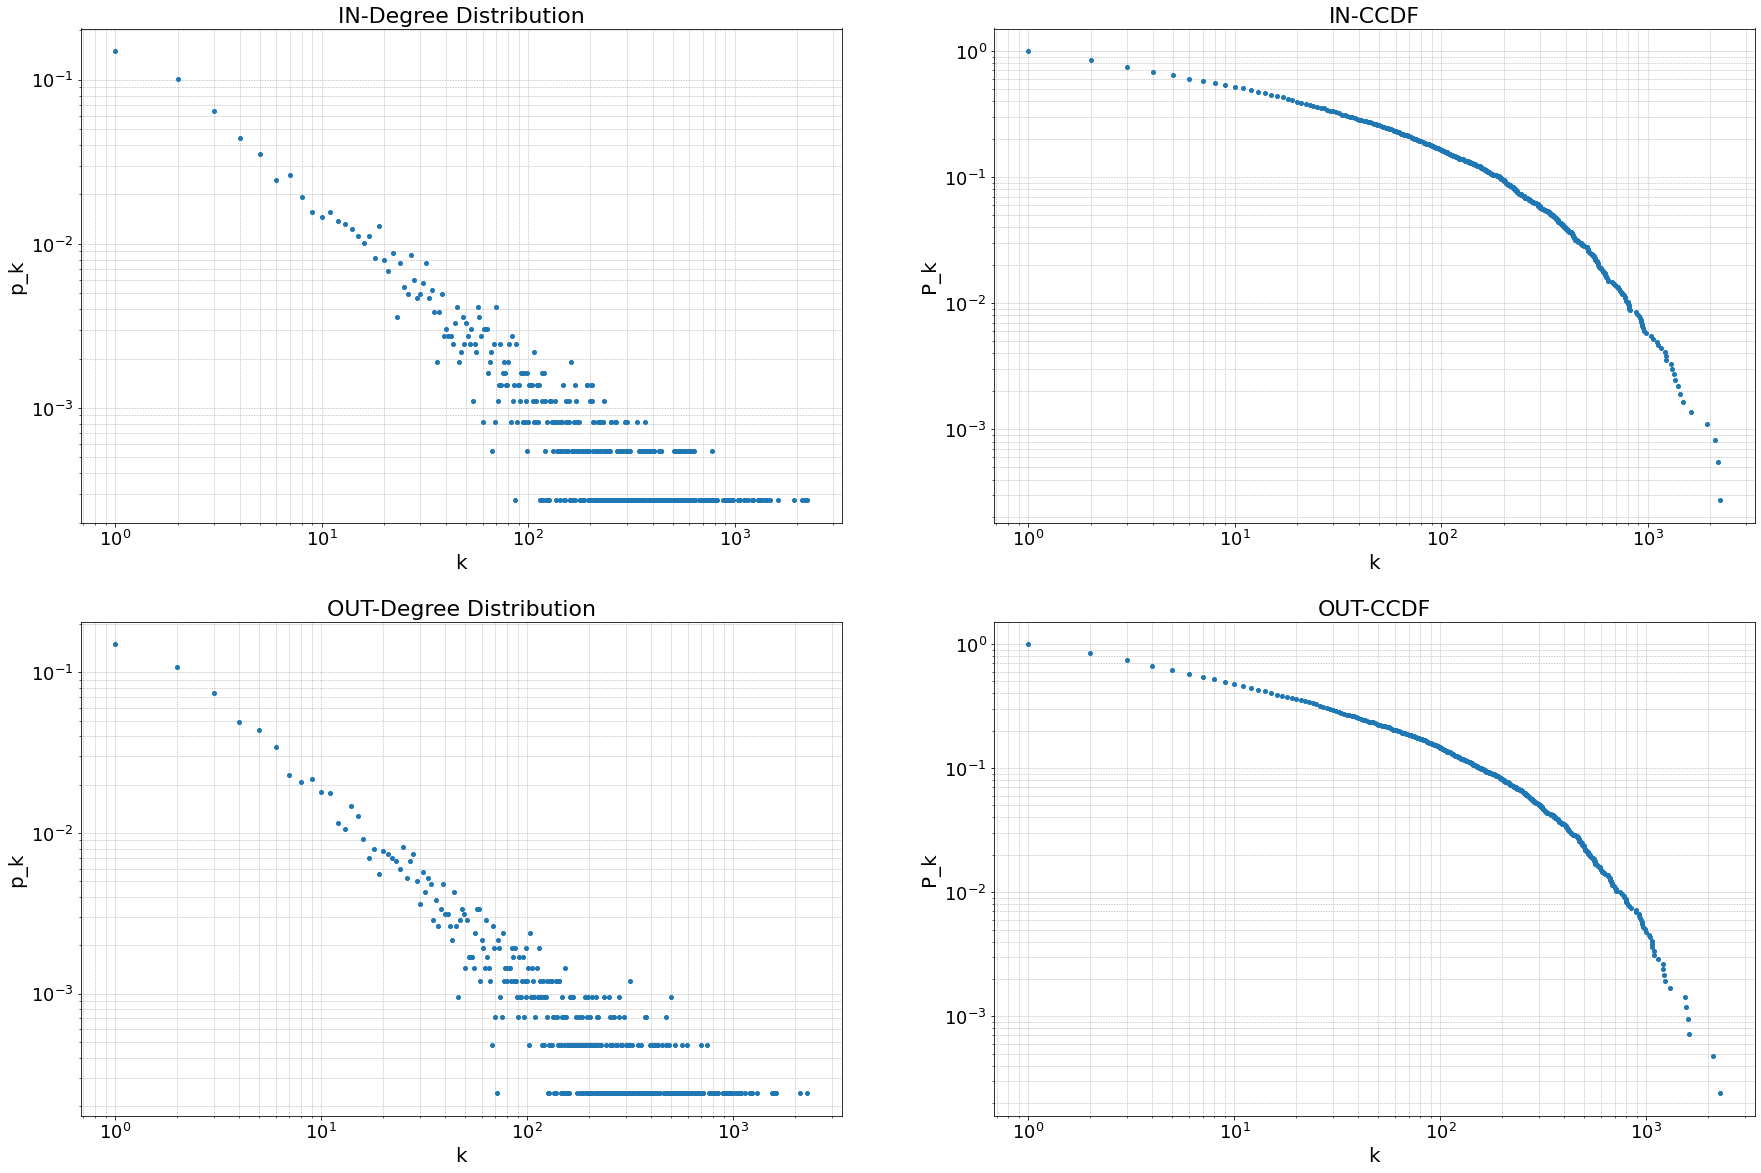

Top 10 for in degree


,Nodes,in degree
4440,UNIVERSITAT DE VALENCIA,2239
2460,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2181
18,UNIVERSIDADE DE LISBOA,2118
2293,UNIVERSIDAD DE GRANADA,1934
468,UNIVERSIDAD COMPLUTENSE DE MADRID,1615
1292,UNIVERZA V LJUBLJANI,1483
2121,UNIVERSITAT POLITECNICA DE VALENCIA,1436
4196,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,1406
2059,UNIVERSIDAD DE SEVILLA,1352
1232,KATHOLIEKE UNIVERSITEIT LEUVEN,1340


Top 10 for out degree


,Nodes,out degree
2460,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2280
2293,UNIVERSIDAD DE GRANADA,2114
4440,UNIVERSITAT DE VALENCIA,1604
468,UNIVERSIDAD COMPLUTENSE DE MADRID,1590
4432,UNIVERSITA DEGLI STUDI DI PADOVA,1563
2784,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,1544
378,UNIVERSITA DEGLI STUDI DI TORINO,1299
18,UNIVERSIDADE DE LISBOA,1230
1232,KATHOLIEKE UNIVERSITEIT LEUVEN,1218
1137,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,1206


In [143]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### HITS (NetworkX)

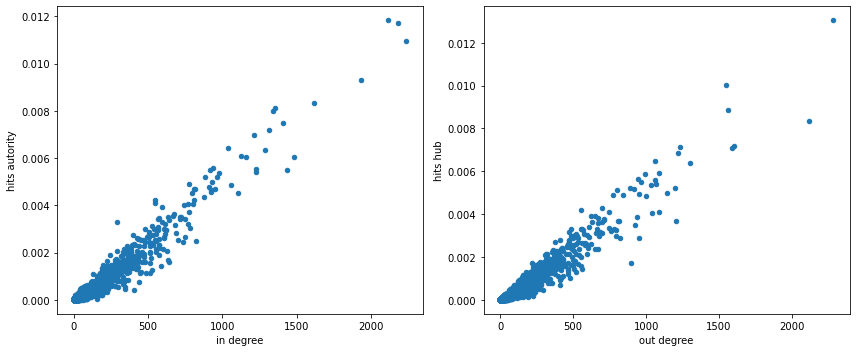

Top 10 for hits hub


,Nodes,hits hub
2460,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.013047
2784,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.010031
4432,UNIVERSITA DEGLI STUDI DI PADOVA,0.008866
2293,UNIVERSIDAD DE GRANADA,0.008332
4440,UNIVERSITAT DE VALENCIA,0.007194
18,UNIVERSIDADE DE LISBOA,0.007115
468,UNIVERSIDAD COMPLUTENSE DE MADRID,0.007101
1232,KATHOLIEKE UNIVERSITEIT LEUVEN,0.006870
3066,TECHNISCHE UNIVERSITAET MUENCHEN,0.006476
378,UNIVERSITA DEGLI STUDI DI TORINO,0.006369


Top 10 for hits autority


,Nodes,hits autority
18,UNIVERSIDADE DE LISBOA,0.011827
2460,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.011717
4440,UNIVERSITAT DE VALENCIA,0.010963
2293,UNIVERSIDAD DE GRANADA,0.009295
468,UNIVERSIDAD COMPLUTENSE DE MADRID,0.008322
2059,UNIVERSIDAD DE SEVILLA,0.008102
1232,KATHOLIEKE UNIVERSITEIT LEUVEN,0.007990
4196,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.007498
4895,UNIVERZITA KARLOVA,0.007183
1046,UNIVERSITAT DE BARCELONA,0.006963


In [144]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

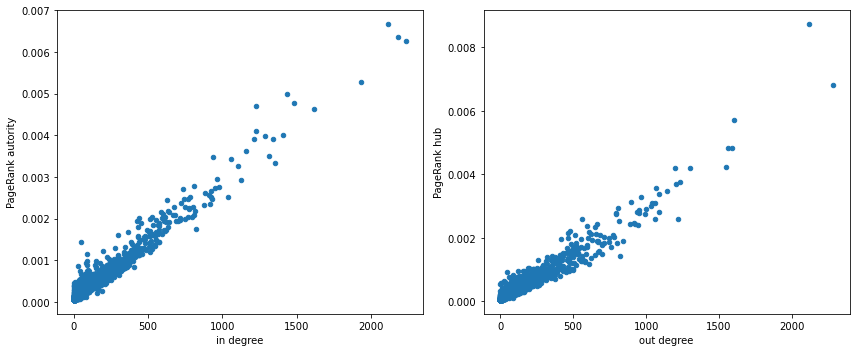

Top 10 for PageRank hub


,Nodes,PageRank hub
2293,UNIVERSIDAD DE GRANADA,0.008724
2460,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006795
4440,UNIVERSITAT DE VALENCIA,0.005713
468,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004827
4432,UNIVERSITA DEGLI STUDI DI PADOVA,0.004826
2784,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.004223
4521,UNIVERSIDAD POLITECNICA DE MADRID,0.004187
378,UNIVERSITA DEGLI STUDI DI TORINO,0.004185
18,UNIVERSIDADE DE LISBOA,0.003746
1137,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,0.003685


Top 10 for PageRank autority


,Nodes,PageRank autority
18,UNIVERSIDADE DE LISBOA,0.006671
2460,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006371
4440,UNIVERSITAT DE VALENCIA,0.006263
2293,UNIVERSIDAD DE GRANADA,0.005291
2121,UNIVERSITAT POLITECNICA DE VALENCIA,0.004997
1292,UNIVERZA V LJUBLJANI,0.004764
2870,POLITECNICO DI MILANO,0.004715
468,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004639
4432,UNIVERSITA DEGLI STUDI DI PADOVA,0.004098
4196,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.004001


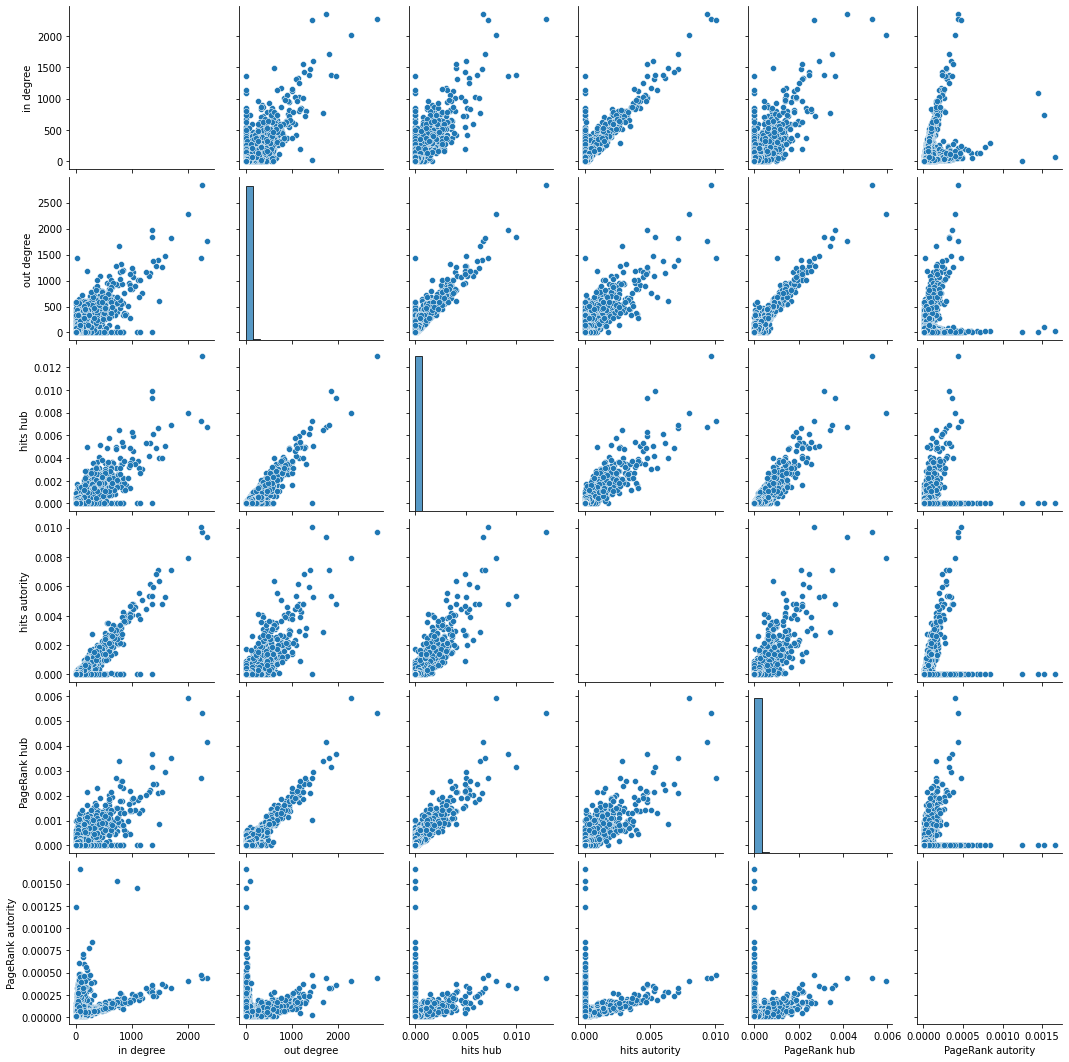

In [145]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')
# ci vuole troppo a farlo
# sns.pairplot(scores)
# plt.show()
from IPython.display import Image
Image('pairplot_score.png',)

### Assortativity

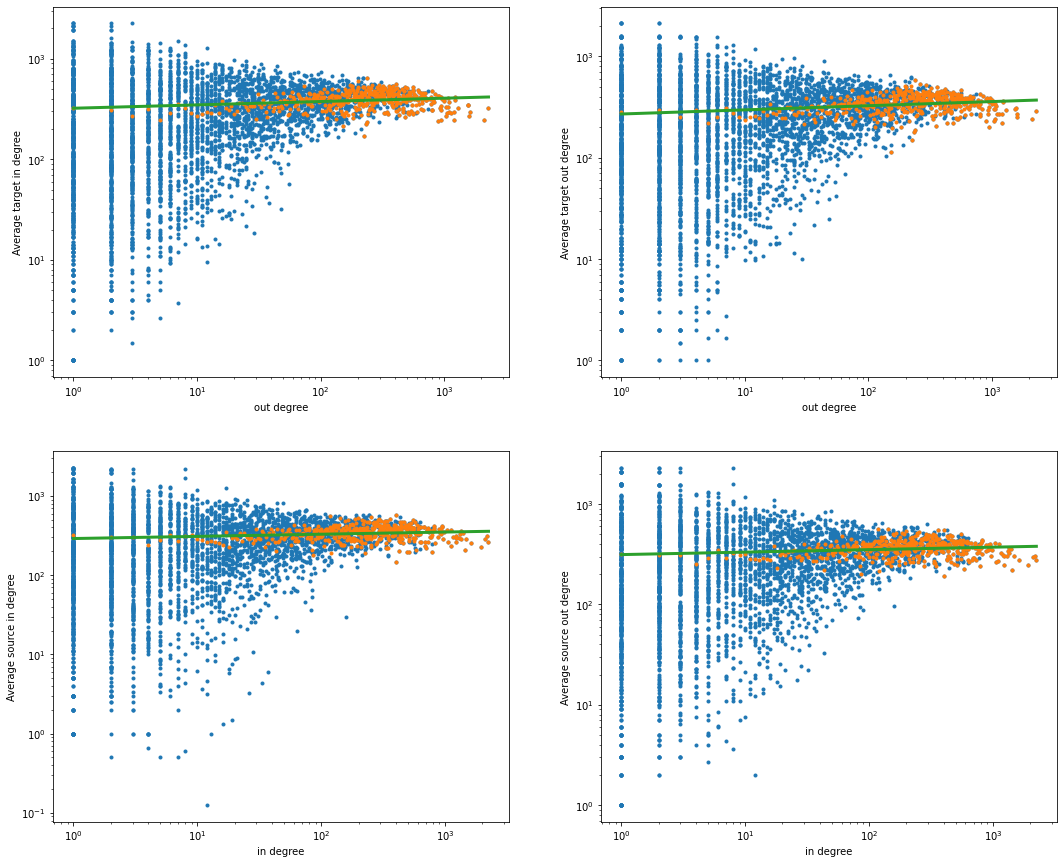

(0.03327460057579346,
 0.0408980364797933,
 0.027284988609938908,
 0.024645650714904696)

In [146]:
edges = mobility_df.copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)